In [3]:
import joblib
import javalang
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load the preprocessed data
data_path = r'C:\Users\droid\Documents\Aplicaciones_Avanzadas\Proyecto\PlagiarismDetector\Preprocessing\preprocessed_all_data.pkl'
X, y, tfidf_vectorizer = joblib.load(data_path)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [6]:
# Predict on training data
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_loss = log_loss(y_train, model.predict_proba(X_train))

In [7]:
# Predict on test data
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_loss = log_loss(y_test, model.predict_proba(X_test))

In [8]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

Train Accuracy: 1.0
Train Loss: 0.006374523382789049
Test Accuracy: 0.9166666666666666
Test Loss: 0.29742697198580426

Confusion Matrix:


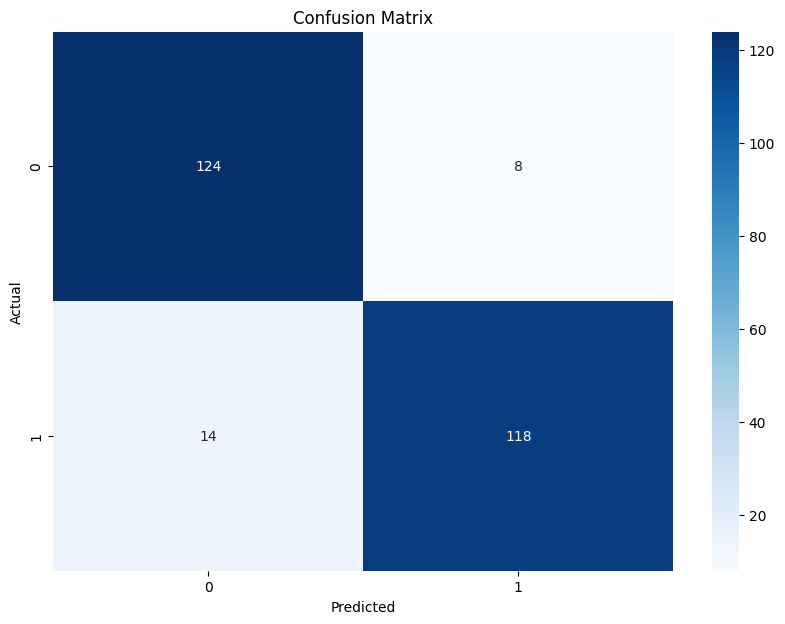

In [13]:
# Print metrics
print(f"Train Accuracy: {train_acc}")
print(f"Train Loss: {train_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
print('')
print("Confusion Matrix:")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Save the trained model
model_path = r'C:\Users\droid\Documents\Aplicaciones_Avanzadas\Proyecto\PlagiarismDetector\Modeling\XGBoost\xgboost_model.pkl'
joblib.dump(model, model_path)

['C:\\Users\\droid\\Documents\\Aplicaciones_Avanzadas\\Proyecto\\PlagiarismDetector\\Modeling\\XGBoost\\xgboost_model.pkl']

In [16]:
# Function to test the model using external files
def test_model_on_external_files(file1_path, file2_path, model_path, tfidf_vectorizer):
    model = joblib.load(model_path)
    
    def read_java_file(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return content

    def extract_ast_nodes(code):
        try:
            tokens = list(javalang.tokenizer.tokenize(code))
            parser = javalang.parser.Parser(tokens)
            tree = parser.parse()

            ast_nodes = []
            for path, node in tree:
                if isinstance(node, javalang.tree.Node):
                    ast_nodes.append(node.__class__.__name__)
            return ' '.join(ast_nodes)
        except (javalang.parser.JavaSyntaxError, javalang.tokenizer.LexerError) as e:
            print(f"Error parsing Java code: {e}")
            return ''

    code1 = read_java_file(file1_path)
    code2 = read_java_file(file2_path)
    ast_nodes1 = extract_ast_nodes(code1)
    ast_nodes2 = extract_ast_nodes(code2)

    if ast_nodes1 and ast_nodes2:
        combined_ast_nodes = ast_nodes1 + ' ' + ast_nodes2
        combined_features = tfidf_vectorizer.transform([combined_ast_nodes])
        
        ast_set1 = set(ast_nodes1.split())
        ast_set2 = set(ast_nodes2.split())

        # Calculate additional features
        jaccard_similarity = len(ast_set1.intersection(ast_set2)) / len(ast_set1.union(ast_set2)) if len(ast_set1.union(ast_set2)) != 0 else 0
        vec1 = tfidf_vectorizer.transform([ast_nodes1]).toarray()[0]
        vec2 = tfidf_vectorizer.transform([ast_nodes2]).toarray()[0]
        manhattan_distance = np.sum(np.abs(vec1 - vec2))

        # Combine all features
        additional_features = np.array([[manhattan_distance, jaccard_similarity]])
        combined_features = np.hstack((combined_features.toarray(), additional_features))

        # Predict using the model
        prediction = model.predict(combined_features)
        return prediction[0]
    else:
        print("Error: AST extraction failed for one or both files.")
        return None

In [17]:
# Example usage of the test function
file1 = r'C:\Users\droid\Documents\Aplicaciones_Avanzadas\Proyecto\PlagiarismDetector\Modeling\TestFiles\case-04\original\T4.java'
file2 = r'C:\Users\droid\Documents\Aplicaciones_Avanzadas\Proyecto\PlagiarismDetector\Modeling\TestFiles\case-04\non-plagiarized\02\T04.java'
result = test_model_on_external_files(file1, file2, model_path, tfidf_vectorizer)
print(f"Prediction for the external files: {result}")

Prediction for the external files: 0
